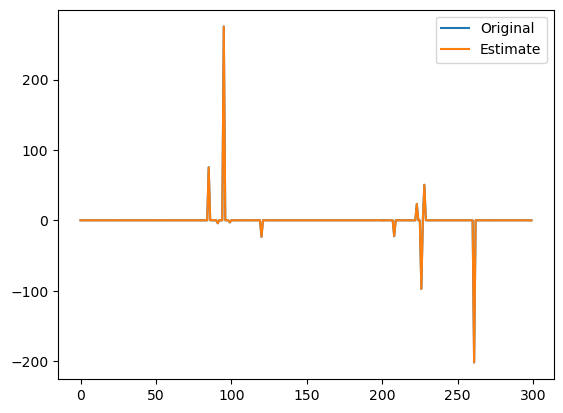

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log
from sklearn.metrics import mean_squared_error as mse 
from scipy.linalg import cholesky, svd, solve_triangular
from time import time



def Sthresh(x, gamma):
    return np.sign(x)*np.maximum(0, np.absolute(x)-gamma/2.0)

def ADMM(A, y, A_test=None, y_test=None, MAX_ITER = 100_000):
    lossses = []
    m, n = A.shape
    w, v = np.linalg.eig(A.T.dot(A))
    

    "Function to caluculate min 1/2(y - Ax) + l||x||"
    "via alternating direction methods"
    xhat = np.zeros([n, 1])
    zhat = np.zeros([n, 1])
    u = np.zeros([n, 1])

    "Calculate regression co-efficient and stepsize"
    l = sqrt(2*log(n, 10))
    rho = 1/(np.amax(np.absolute(w)))

    "Pre-compute to save some multiplications"
    AtA = A.T.dot(A)
    Aty = A.T.dot(y)
    Q = AtA + rho*np.identity(n)
    Q = np.linalg.inv(Q)

    i = 0
    times = []
    curr_time = 0

    while(i < MAX_ITER):
        t0 = time()
        "x minimisation step via posterier OLS"
        xhat = Q.dot(Aty + rho*(zhat - u))

        "z minimisation via soft-thresholding"
        zhat = Sthresh(xhat + u, l/rho)

        "mulitplier update"
        u += xhat - zhat

        i += 1
        if A_test is not None:
            lossses.append(mse(y_test, A_test@zhat))
        else:
            lossses.append(mse(y, A@zhat))
        t1 = time()
        times.append(curr_time + t1 - t0)
        curr_time = times[-1]
    return zhat, rho, l, lossses, times


n, m = 70, 300

A = np.random.randn(n, m)

num_non_zeros = 10
positions = np.random.randint(0, m, num_non_zeros)
amplitudes = 100*np.random.randn(num_non_zeros, 1)
x = np.zeros((m, 1))
x[positions] = amplitudes


y = A.dot(x) + np.random.randn(n, 1) 

xhat, rho, l, losses, times = ADMM(A, y, MAX_ITER=10_000)

plt.plot(x, label='Original')
plt.plot(xhat, label = 'Estimate')

plt.legend(loc = 'upper right')

plt.show()

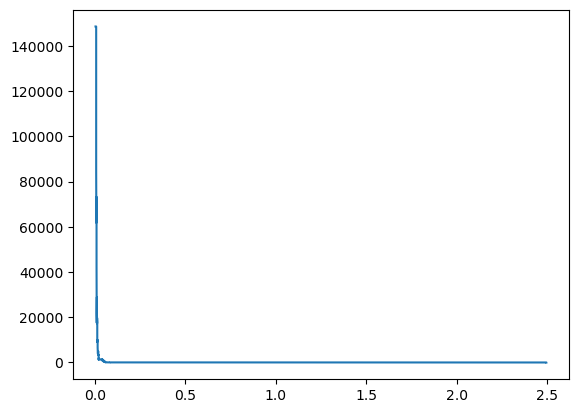

In [2]:
plt.plot(times, losses)

In [3]:
epsilon = lambda x: 1 / (1 + x ** 7)
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def nystrom_approximation(H, s, eps=epsilon):
    print(is_pos_def(H))
    d = H.shape[0]
    Omega = np.random.normal(0, 1, (d, s)) # Gaussian test matrix
    Omega, _ = np.linalg.qr(Omega, mode='reduced')
    Y = H @ Omega
    nu = eps(np.linalg.norm(Y, 2))
    Y_nu = Y + nu * Omega
    print(is_pos_def(Omega.T @ Y_nu))
    C = cholesky(Omega.T @ Y_nu)
    B = solve_triangular(C, Y_nu.T, lower=False, trans='T').T 
    U, Sigma, _ = svd(B, full_matrices=False)
    Id = np.ones(Sigma.shape)
    lambda_prime = np.maximum(0, Sigma ** 2 - nu * Id)
    return U, np.diag(lambda_prime)

# from lecture
def accurate_randomized_svd(A, rank, p, q):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    for i in range(q):
        W = A.T @ Q
        W, _ = np.linalg.qr(W)
        Q = A @ W
        Q, _ = np.linalg.qr(Q)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V


eps_k = lambda k: 1 / (1 + k**2)

def inverse_diagonal_matrix(D):
    diagonal_elements = D.diagonal()
    D_inv = np.diag(1 / diagonal_elements)
    return D_inv

def get_preconditioner_inv(U, S, s, ro):
    diag_elements = S.diagonal()
    lambda_s = diag_elements[-1]
    I = np.eye(S.shape[0])
    D = S + ro * I
    D_inv = inverse_diagonal_matrix(D)
    P_inv = (lambda_s + ro) * U @ D_inv @ U.T + (np.eye(U.shape[0]) - U @ U.T)
    return P_inv

def nystrom_pcg(H, U, S, r, x0, ro=0.01, s=50, epsilon=0.05):
    #U, S = nystrom_approximation(H, s)
    
    I = np.eye(H.shape[0])
    w0 = r - (H + ro * I) @ x0

    P_inv = get_preconditioner_inv(U, S, s, ro)

    y0 = P_inv @ w0
    p0 = y0.copy()
    x = x0
    while np.linalg.norm(w0) > epsilon:
        v = (H + ro * I) @ p0
        alpha = (w0.T @ y0) / (p0.T @ v)
        x = x0 + alpha * p0
        w = w0 - alpha * v
        y = P_inv @ w
        beta = (w.T @ y) / (w0.T @ y0)
        x0, w0, p0, y0 = x, w, y + beta * p0, y

    return x  # Output approximate solution x*

In [4]:
def NysADMM(A, y, A_test=None, y_test=None, MAX_ITER = 100_000):
    lossses = []
    m, n = A.shape
    w, v = np.linalg.eig(A.T.dot(A))
    

    "Function to caluculate min 1/2(y - Ax) + l||x||"
    "via alternating direction methods"
    xhat = np.zeros([n, 1])
    zhat = np.zeros([n, 1])
    u = np.zeros([n, 1])

    "Calculate regression co-efficient and stepsize"
    l = sqrt(2*log(n, 10))
    rho = 1/(np.amax(np.absolute(w)))

    "Pre-compute to save some multiplications"
    AtA = A.T.dot(A)
    Aty = A.T.dot(y)
    Q = AtA + rho*np.identity(n)
   

    U, S = nystrom_approximation(Q, s=50)
    #print(np.linalg.norm(Q - U@S@U.T))
    #Q = U@S@U.T
    #Q_inv = np.linalg.inv(Q)
    times = []
    curr_time = 0

    for _ in range(MAX_ITER):
        "x minimisation step via posterier OLS"
        t0 = time()
        r = Aty
        xhat = nystrom_pcg(Q.copy(), U, S, r, rho*(zhat - u), ro=rho, s=50, epsilon=0.1)
        #xhat = Q_inv @ r

        "z minimisation via soft-thresholding"
        zhat = Sthresh(xhat + u, l/rho)

        "mulitplier update"
        u += xhat - zhat

        if A_test is not None:
            lossses.append(mse(y_test, A_test@zhat))
        else:
            lossses.append(mse(y, A@zhat))
        t1 = time()
        times.append(curr_time + t1 - t0)
        curr_time = times[-1]

        
    return zhat, rho, l, lossses, times

True
True
0.0002690789437669151
4.540139335345115
4.540139335345093


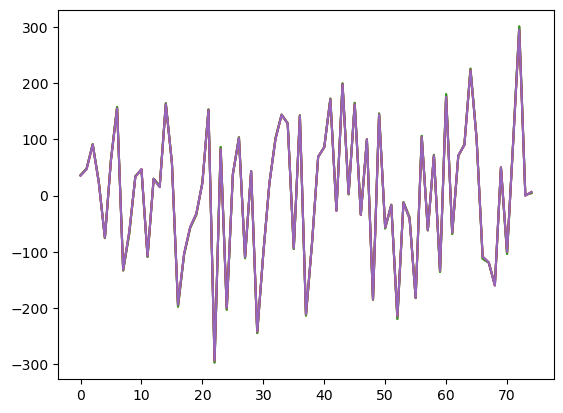

In [25]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import numpy as np
import warnings
from time import time
warnings.filterwarnings("ignore")


lr = Lasso(max_iter=1, warm_start=True, fit_intercept=False)
lr2 = Lasso(max_iter=1, warm_start=True, selection='random', fit_intercept=False)


A, y = make_regression(n_samples=300, n_features=100, n_informative=5)
A_tr, A_tt, y_tr, y_tt = train_test_split(A, y)

iters = 5_000


x_one = np.linalg.inv(A_tr.T @ A_tr) @ A_tr.T @ y_tr.reshape(-1, 1)


xhat, rho, l, losses, times = ADMM(A_tr, y_tr.reshape(-1, 1),  A_tt, y_tt, 10_000)
xhat_nys, _, _, losses_nys, times_nys = NysADMM(A_tr, y_tr.reshape(-1, 1),  A_tt, y_tt, 2_000)

lasso_losses = []
lasso_times = []
lct = 0

rand_lasso_losses = []
rand_lasso_times = []
rlct = 0

for _ in range(iters):
    t0 = time()
    lr.fit(A_tr, y_tr)
    preds = lr.predict(A_tt)
    lasso_losses.append(mse(y_tt, preds))
    t1 = time()
    lasso_times.append(lct + t1 - t0)
    lct = lasso_times[-1]

    t0 = time()
    lr2.fit(A_tr, y_tr)
    rand_preds = lr2.predict(A_tt)
    rand_lasso_losses.append(mse(y_tt, rand_preds))
    t1 = time()
    rand_lasso_times.append(rlct + t1 - t0)
    rlct = rand_lasso_times[-1]


plt.plot(y_tt)
plt.plot(A_tt@xhat)
plt.plot(A_tt@xhat_nys)
plt.plot(lr.predict(A_tt))
plt.plot(lr2.predict(A_tt))

print(mse(y_tt, A_tt@xhat))
print(mse(y_tt, lr.predict(A_tt)))
print(mse(y_tt, lr2.predict(A_tt)))

(0.0, 2.0)

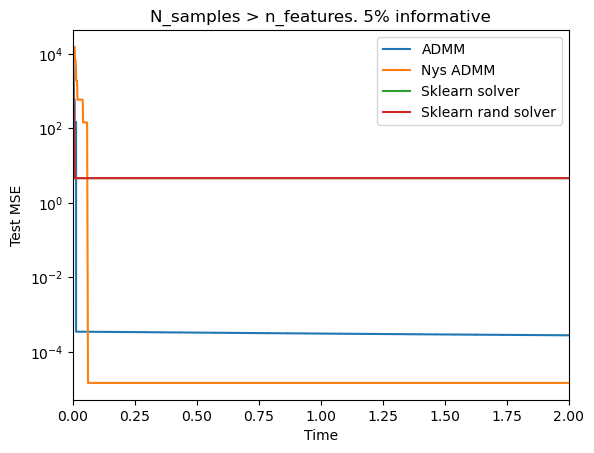

In [27]:

plt.title("N_samples > n_features. 5% informative")
plt.semilogy(times, losses, label="ADMM")
plt.semilogy(times_nys, losses_nys, label="Nys ADMM")
plt.semilogy(lasso_times, lasso_losses, label='Sklearn solver')
plt.semilogy(rand_lasso_times, rand_lasso_losses, label='Sklearn rand solver')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Test MSE")
plt.xlim(0, 2)

In [36]:
from tqdm.auto import tqdm

sizes = [50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800]
iters = 100
times = []
nys_times = []

mses = []
nys_mses = []

for size in tqdm(sizes):
    A, y = make_regression(n_samples=size, n_features=300, n_informative=size//2)
    t1s = time()
    xhat, rho, l, losses, times_admm = ADMM(A, y.reshape(-1, 1), MAX_ITER=iters)
    t1f = time()
    times.append(t1f - t1s)
    mses.append(mse(y, A@xhat))

    t2s = time()
    xhat_nys, _, _, losses_nys, times_nys = NysADMM(A, y.reshape(-1, 1),  MAX_ITER=iters)
    t2f = time()
    nys_mses.append(mse(y, A@xhat_nys))

    nys_times.append(t2f - t2s)

  0%|          | 0/12 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


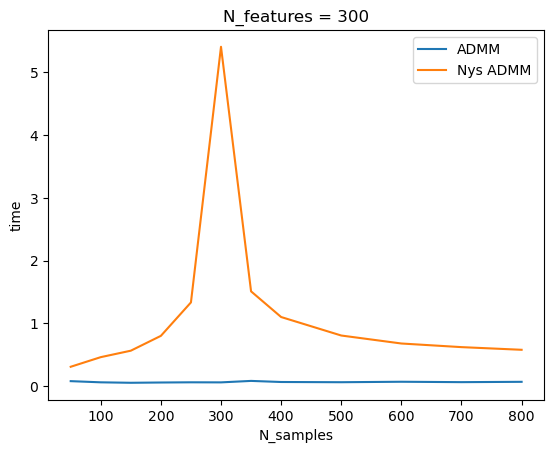

In [38]:
plt.title("N_features = 300")
plt.plot(sizes, times, label="ADMM")
plt.plot(sizes, nys_times, label='Nys ADMM')
plt.xlabel("N_samples")
plt.ylabel("time")
plt.legend()

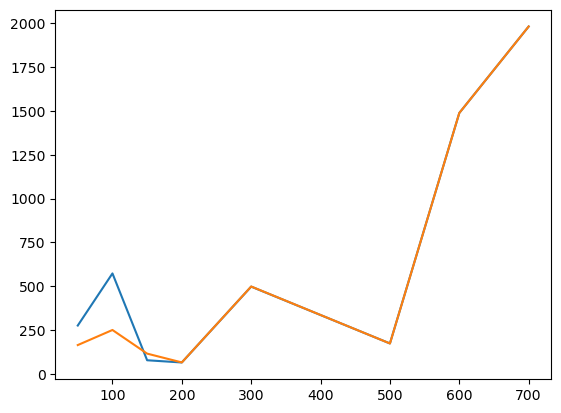

In [33]:
plt.plot(sizes, mses)
plt.plot(sizes, nys_mses)